# Best Location for Supermarket/Grocery Store in Cologne, Germany

### This notebook aims to find the neighborhoods in Cologne that has relatively low Supermarkets/Grocery Store compared the Population Density in the region

### Part 1 Data Scraping

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time

In [2]:
url = 'https://postal-codes.cybo.com/germany/cologne/'
cybopage = requests.get(url).text
soup = BeautifulSoup(cybopage,'lxml')
table = soup.find_all('table')

#### Get general information of Cologne

In [3]:
Cologne_General = {}
temp = []
for row in table[0].find_all('tr'):
    '''Scrape the first table with General information'''
    for col in row.find_all('td'):
        if col.text.strip() == '':
            break
        temp.append(col.text.strip())
    if temp != []:
        Cologne_General.update({temp[0]:temp[1]})
        temp = []

CologneGeneral = pd.Series(Cologne_General).to_frame('Information')
CologneGeneral

Information
Timezone                   Central European Time
Area                                   281.7 km²
Population                977,691 (More Details)
Male Population                  473,826 (48.5%)
Female Population                503,864 (51.5%)
Median Age                                  41.3
Postal Codes       50667, 50668, 50670 (43 more)
Area Codes                             2203, 221

In [4]:
def getdetailsofPLZ(link):
    '''A Function to check the details of postal code, in the target website'''
    
    def split_LatLong(row):
        '''Function to split the coordinates into Latitude and Longtitude'''
        splitted = row['Coordinates'].split('/')
        return splitted[0], splitted[1]
    

    sample_df = pd.read_html(link)
    
    rqdf = sample_df[0].T # Transpose the obtained dataframe so that features are in columns
    rqdf.columns = rqdf.loc[0] #Make the first row as column headers
    rqdf.drop(0,inplace=True) #Drop the first row as they are already named as column headers
    
    # use zip to create the Latitude and Longitude columns
    rqdf['Latitude'], rqdf['Longitude'] = zip(*rqdf.apply(split_LatLong, axis=1))
    
    #Filter the required fields for our analysis
    try:
        rqdf = rqdf[['Area Codes', 'Neighborhoods', 'Latitude','Longitude','Male Population','Female Population','Median Age','Male Median Age','Female Median Age']]
    except:
        rqdf = rqdf[['Area Codes', 'Neighborhoods', 'Latitude','Longitude']]
#        ['Male Population','Female Population','Median Age','Male Median Age','Female Median Age']
    
    rqdf.reset_index()
    
    return rqdf.to_dict('list')

### Scrape the main table i.e., table[1] with list of postal codes. The postal code is also a hyperlink that contains further details of postal code like Neighbourhoods and Coordinates. They are also scraped and combined in the end.

In [6]:
#PostalCodes
Cologne_PLZ,Cologne_PLZ_Detail = {},{}
header,tmp = [],[]
valid_link = ''

#Scrape the headers from 'th' tag
for thead in table[1].find_all('thead'):
    for hdr in thead.find_all('th'):
        header.append(hdr.text)
        
#Scrape the 'tr' and 'td' tag to collect the data
for row in table[1].find_all('tr'):
    for inf in row.find_all('td'):
        tmp.append(inf.text)
        if inf(href=True):
            link =inf.text
            # A simple validation if the link is a postal code link starting with 50XXX or 51XXX 
            if re.search('[5][0|1]\d{3}',link):
                link = 'http:'+inf.find('a')['href']
                valid_link = link
    if valid_link != '' and tmp[0] != '50923':
        further_info = getdetailsofPLZ(valid_link)
        
        # Once the a particular row with postal code and details link is scraped, validate and update a dictionary
        if len(header)==len(tmp):
            for i in range(len(header)):
                if header[i] in Cologne_PLZ:
                    Cologne_PLZ[header[i]].append(tmp[i])
                else:
                    Cologne_PLZ[header[i]] = [tmp[i]]
            for i in further_info:
                if i in Cologne_PLZ:
                    Cologne_PLZ[i].append(further_info[i][0])
                else:
                    Cologne_PLZ.update({i:[further_info[i][0]]})
            print(' Processed PLZ - ',Cologne_PLZ['Postal Code'][-1])
            #time.sleep(3) #So that the website does not blacklist ustime.sleep(3)
        else:
            print('header not equal to tmp')
    tmp = []
    valid_link = ''

df_ColognePLZ = pd.DataFrame.from_dict(Cologne_PLZ)

 Processed PLZ -  50667
 Processed PLZ -  50668
 Processed PLZ -  50670
 Processed PLZ -  50672
 Processed PLZ -  50674
 Processed PLZ -  50676
 Processed PLZ -  50677
 Processed PLZ -  50678
 Processed PLZ -  50679
 Processed PLZ -  50733
 Processed PLZ -  50735
 Processed PLZ -  50737
 Processed PLZ -  50739
 Processed PLZ -  50765
 Processed PLZ -  50767
 Processed PLZ -  50769
 Processed PLZ -  50823
 Processed PLZ -  50825
 Processed PLZ -  50827
 Processed PLZ -  50829
 Processed PLZ -  50858
 Processed PLZ -  50859
 Processed PLZ -  50931
 Processed PLZ -  50933
 Processed PLZ -  50935
 Processed PLZ -  50937
 Processed PLZ -  50939
 Processed PLZ -  50968
 Processed PLZ -  50969
 Processed PLZ -  50996
 Processed PLZ -  50997
 Processed PLZ -  50999
 Processed PLZ -  51061
 Processed PLZ -  51063
 Processed PLZ -  51065
 Processed PLZ -  51067
 Processed PLZ -  51069
 Processed PLZ -  51103
 Processed PLZ -  51105
 Processed PLZ -  51107
 Processed PLZ -  51109
 Processed PLZ -

#### Correcting the largest Postal Code of Cologne, To cover happening areas to find venues. 
#### The Scraped website shows very loosely populated areas for Lat and Long which is corrected

In [12]:

OLD_LAT = df_ColognePLZ[df_ColognePLZ['Postal Code'] == '50769']['Latitude']
OLD_LON = df_ColognePLZ[df_ColognePLZ['Postal Code'] == '50769']['Longitude']
NEW_LAT = 51.038458
NEW_LON = 6.908730
print('Changing OLD LAT {} to {}'.format(OLD_LAT,NEW_LAT))
df_ColognePLZ['Latitude'].loc[df_ColognePLZ['Postal Code'] == '50769'] = NEW_LAT
print('Changing OLD LON %s to %s'.format(OLD_LON,NEW_LON))
df_ColognePLZ['Longitude'].loc[df_ColognePLZ['Postal Code'] == '50769'] = NEW_LON

Changing OLD LAT 15    51.0385
Name: Latitude, dtype: object to 51.038458
Changing OLD LON %s to %s


In [13]:
Cologne_Demographic = {}
temp = []
for row in table[2].find_all('tr'):
    '''Scrape the third table with General information'''
    for col in row.find_all('td'):
        if col.text.strip() == '':
            break
        temp.append(col.text.strip())
    if temp != []:
        Cologne_Demographic.update({temp[0]:temp[1]})
        temp = []

CologneDemographic = pd.Series(Cologne_Demographic).to_frame('Information')
CologneDemographic

Information
Population                                   977,691
Population Density                       3,470 / km²
Male Population                      473,826 (48.5%)
Female Population                    503,864 (51.5%)
Median Age                                      41.3
Male Median Age                                 40.5
Female Median Age                                 42
Businesses in Cologne                         85,523
Population (1975)                            702,101
Population (2000)                            892,156
Population change from 1975 to 2015           +39.3%
Population change from 2000 to 2015            +9.6%

In [14]:
df_ColognePLZ.to_csv('ColognePostCodes.csv')

### Part 2 - Exploratory Data Anaylysis

In [15]:
import folium 
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import branca 
import numpy as np
import geopandas as gpd

In [16]:
with open('new_plzcologne.json') as jsonfile:
    cologne_json = json.load(jsonfile)

In [48]:
df_colognedata = pd.read_csv('ColognePostCodes.csv')
#df_colognedata = df_colognedata[['Postal Code','Population','Area','Neighborhoods','Latitude','Longitude']]

#Dropping PostCode 50923 due to insufficient data
df_colognedata.drop(df_colognedata[df_colognedata['Postal Code']==50923].index,inplace=True)

In [49]:
df_colognedata['Population'] = df_colognedata['Population'].str.replace(',','')
df_colognedata['Population'] = df_colognedata['Population'].astype('int')
df_colognedata['Area'] = df_colognedata['Area'].str.replace('km²','')
df_colognedata['Area'] = df_colognedata['Area'].astype('float')
df_colognedata['Latitude'] = df_colognedata['Latitude'].str.replace('°','')
df_colognedata['Longitude'] = df_colognedata['Longitude'].str.replace('°','')
df_colognedata['Latitude'] = df_colognedata['Latitude'].astype('float64') 
df_colognedata['Longitude'] = df_colognedata['Longitude'].astype('float64')

In [50]:
df_colognedata['Population Density'] = df_colognedata['Population']/df_colognedata['Area']
df_colognedata['Postal Code'] = df_colognedata['Postal Code'].astype('str')

In [106]:
df_colognedata.head()

Unnamed: 0 Postal Code     City   Administrative Region  Population   Area  \
0           0       50667  Cologne  North Rhine-Westphalia        4512  1.031   
1           1       50668  Cologne  North Rhine-Westphalia        7717  1.692   
2           2       50670  Cologne  North Rhine-Westphalia        8612  1.900   
3           3       50672  Cologne  North Rhine-Westphalia        4657  1.027   
4           4       50674  Cologne  North Rhine-Westphalia        6643  1.389   

  Area Codes                                Neighborhoods   Latitude  \
0  2203, 221                    Altstadt-Nord, Innenstadt  50.940089   
1  2203, 221  Altstadt-Nord, Innenstadt, Kunibertsviertel  50.950695   
2  2203, 221                     Agnesviertel, Innenstadt  50.951172   
3  2203, 221                   Friesenviertel, Innenstadt  50.943441   
4  2203, 221                  Innenstadt, Rathenauviertel  50.933584   

   Longitude  Male Population  Female Population  Median Age  Male Median Age  \
0   6.957685             2187               2325  41.3 years             40.5   
1   6.965450             3740               3977  41.3 years             40.5   
2   6.950957             4174               4438  41.3 years             40.5   
3   6.938476             2257               2400  41.3 years             40.5   
4   6.937041             3219               3424  41.3 years             40.5   

   Female Median Age  Population Density    PLZ binned  
0               42.0         4376.333657  50667    400  
1               42.0         4560.874704  50668    400  
2               42.0         4532.631579  50670    400  
3               42.0         4534.566699  50672    400  
4               42.0         4782.577394  50674    400

In [51]:
print("Total Population in Cologne Germany, is about {}".format(df_colognedata['Population'].sum()))


Total Population in Cologne Germany, is about 1046324


In [21]:
from branca.colormap import linear

colormap = linear.Blues_09.scale(
    df_colognedata['Population'].min(), df_colognedata['Population'].max()
)
colormapdensity = linear.Blues_09.scale(
    df_colognedata['Population Density'].min(), df_colognedata['Population Density'].max()
)
print(colormap(5.0))

colormap

#f7fbffff


In [22]:
population_dict = df_colognedata.set_index('Postal Code')['Population']
Population_density_dict = df_colognedata.set_index('Postal Code')['Population Density']

### Here is the map of cologne in Folium. It can be seen that Outer regions have high population. Inner city has relatively lesser population. However note that Area is also large

In [107]:
mpopulation = folium.Map(location = [50.935173,6.953101],tiles='cartodbpositron',zoom_start = 11)
folium.GeoJson(cologne_json,
               name="Population",
              style_function=lambda feature: {
        "fillColor": colormap(population_dict[feature["properties"]["NUMMER"]]),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity":0.9,
    },).add_to(mpopulation)
colormap.caption = "Population"
colormap.add_to(mpopulation)
mpopulation

### As we know, Population Density is important for closeness of the Supermarket. We will focus and visualise on population density map of Cologne. Which shows quite interesting result.

In [24]:
color_dict = {key: colormapdensity(Population_density_dict[key]) for key in Population_density_dict.keys()}

In [27]:
mdensity = folium.Map(location = [50.935173,6.953101],tiles='cartodbpositron',zoom_start = 11)
folium.GeoJson(cologne_json,
               name="Population Density",
              style_function=lambda feature: {
        "fillColor": color_dict[feature["properties"]["NUMMER"]],
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity":0.9,
    },).add_to(mdensity)
colormapdensity.caption = "Population Density"
colormapdensity.add_to(mdensity)
mdensity

### It can be seen that the inner city is very densely populated compared to the outer regions of city. A defining factor indeed for Supermarket.

In [59]:
df_colognedata.head()

Unnamed: 0 Postal Code     City   Administrative Region  Population   Area  \
0           0       50667  Cologne  North Rhine-Westphalia        4512  1.031   
1           1       50668  Cologne  North Rhine-Westphalia        7717  1.692   
2           2       50670  Cologne  North Rhine-Westphalia        8612  1.900   
3           3       50672  Cologne  North Rhine-Westphalia        4657  1.027   
4           4       50674  Cologne  North Rhine-Westphalia        6643  1.389   

  Area Codes                                Neighborhoods   Latitude  \
0  2203, 221                    Altstadt-Nord, Innenstadt  50.940089   
1  2203, 221  Altstadt-Nord, Innenstadt, Kunibertsviertel  50.950695   
2  2203, 221                     Agnesviertel, Innenstadt  50.951172   
3  2203, 221                   Friesenviertel, Innenstadt  50.943441   
4  2203, 221                  Innenstadt, Rathenauviertel  50.933584   

   Longitude  Male Population  Female Population  Median Age  Male Median Age  \
0   6.957685             2187               2325  41.3 years             40.5   
1   6.965450             3740               3977  41.3 years             40.5   
2   6.950957             4174               4438  41.3 years             40.5   
3   6.938476             2257               2400  41.3 years             40.5   
4   6.937041             3219               3424  41.3 years             40.5   

   Female Median Age  Population Density    PLZ  
0               42.0         4376.333657  50667  
1               42.0         4560.874704  50668  
2               42.0         4532.631579  50670  
3               42.0         4534.566699  50672  
4               42.0         4782.577394  50674

In [ ]:
# Format Male and Female Median Age as number

def adjustvalue(text):
    text = text.replace(',','')
    return int(text[:text.find('(')])
    
df_colognedata['Male Population'] = df_colognedata['Male Population'].apply(adjustvalue)
df_colognedata['Female Population'] = df_colognedata['Female Population'].apply(adjustvalue)

In [55]:
# define temporary column of PLZ as number
df_colognedata['PLZ'] = df_colognedata['Postal Code'].astype(int)

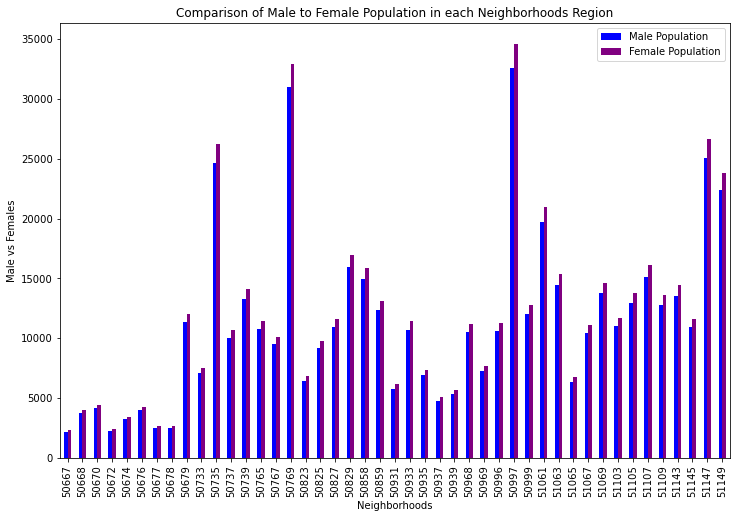

In [56]:

df_colognedata.plot(kind='bar',x='PLZ',y=['Male Population','Female Population'],
                              figsize=(12,8),color=['Blue','Purple'])
plt.title('Comparison of Male to Female Population in each Neighborhoods Region')
plt.xlabel('Neighborhoods')
plt.ylabel('Male vs Females')
plt.show()

#### From the plot, it looks like Female population is slightly more overall in Cologne

### Given a huge city of Cologne, we can also visualise the region we are covering to find the venues details from the Foursquare API. 
### Approach 1 In below code, Proportional area is covered based on the regions total area.

In [64]:
bins = np.linspace(df_colognedata['Area'].min()-1,df_colognedata['Area'].max()+1,10)
labels = [400,450,500,600,750,900,1150,1400,2500]
df_colognedata['binned'] = pd.cut(df_colognedata['Area'], bins=bins, labels=labels)

In [31]:
mchoropleth = folium.Map(location = [50.935173,6.953101],tiles='openstreetmap',zoom_start = 11)
mchoropleth.choropleth(
    geo_data = cologne_json,
    data = df_colognedata,
    columns = ['Postal Code','Population Density'],
    key_on = "feature.properties.NUMMER",
    fill_color="YlGn",
    name = "Population Density in Cologne, Germany",
    )
folium.LayerControl().add_to(mchoropleth)
for lat, lng, label,binned in zip(df_colognedata['Latitude'], df_colognedata['Longitude'], df_colognedata['Neighborhoods'],df_colognedata['binned']):
    label = folium.Popup(label, parse_html=True)
    rad = binned
    folium.Circle(
        [lat, lng],
        radius=rad,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mchoropleth)
mchoropleth

#### It is seen that the proportional area method is not sufficient to cover all the regions in the city. Hence to maximise coverage we can set a default radius of 2000meters for all available Latitude and Longitude

In [32]:
mchoropleth = folium.Map(location = [50.935173,6.953101],tiles='openstreetmap',zoom_start = 11)
mchoropleth.choropleth(
    geo_data = cologne_json,
    data = df_colognedata,
    columns = ['Postal Code','Population Density'],
    key_on = "feature.properties.NUMMER",
    fill_color="YlGn",
    name = "Population Density in Cologne, Germany",
    )
folium.LayerControl().add_to(mchoropleth)
for lat, lng, label,binned in zip(df_colognedata['Latitude'], df_colognedata['Longitude'], df_colognedata['Neighborhoods'],df_colognedata['binned']):
    label = folium.Popup(label, parse_html=True)
    rad = binned
    folium.Circle(
        [lat, lng],
        radius=2000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mchoropleth)
mchoropleth

#### Even though the map looks not so good. This is considered as point for future improvement and we will proceed with finding venues in the above region from Foursquare API

# Part - 3 Finding Venues in the region using FourSquare API

In [62]:
CLIENT_ID = 'QXXXXXXXXXXXxxxxXXXXXXXXxxxxxM' # your Foursquare ID
CLIENT_SECRET = 'NXXXXXXXXXXXxxxxXXXXXXXXxxxxxQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

In [65]:
df_colognedata.head()

Unnamed: 0 Postal Code     City   Administrative Region  Population   Area  \
0           0       50667  Cologne  North Rhine-Westphalia        4512  1.031   
1           1       50668  Cologne  North Rhine-Westphalia        7717  1.692   
2           2       50670  Cologne  North Rhine-Westphalia        8612  1.900   
3           3       50672  Cologne  North Rhine-Westphalia        4657  1.027   
4           4       50674  Cologne  North Rhine-Westphalia        6643  1.389   

  Area Codes                                Neighborhoods   Latitude  \
0  2203, 221                    Altstadt-Nord, Innenstadt  50.940089   
1  2203, 221  Altstadt-Nord, Innenstadt, Kunibertsviertel  50.950695   
2  2203, 221                     Agnesviertel, Innenstadt  50.951172   
3  2203, 221                   Friesenviertel, Innenstadt  50.943441   
4  2203, 221                  Innenstadt, Rathenauviertel  50.933584   

   Longitude  Male Population  Female Population  Median Age  Male Median Age  \
0   6.957685             2187               2325  41.3 years             40.5   
1   6.965450             3740               3977  41.3 years             40.5   
2   6.950957             4174               4438  41.3 years             40.5   
3   6.938476             2257               2400  41.3 years             40.5   
4   6.937041             3219               3424  41.3 years             40.5   

   Female Median Age  Population Density    PLZ binned  
0               42.0         4376.333657  50667    400  
1               42.0         4560.874704  50668    400  
2               42.0         4532.631579  50670    400  
3               42.0         4534.566699  50672    400  
4               42.0         4782.577394  50674    400

In [66]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        radius = 2000
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(name,' Returned Venues:',len(results))
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'PostCode Latitude', 
                  'PostCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

cologneALL_venues = getNearbyVenues(names=df_colognedata['Postal Code'],latitudes=df_colognedata['Latitude'],
                                      longitudes = df_colognedata['Longitude'])
cologneALL_venues.to_csv('CologneFoursquare_Backup.csv')

#cologneALL_venues = pd.read_csv('CologneFoursquare_Backup.csv')

50667  Returned Venues: 100
50668  Returned Venues: 100
50670  Returned Venues: 100
50672  Returned Venues: 100
50674  Returned Venues: 100
50676  Returned Venues: 100
50677  Returned Venues: 100
50678  Returned Venues: 100
50679  Returned Venues: 100
50733  Returned Venues: 100
50735  Returned Venues: 37
50737  Returned Venues: 29
50739  Returned Venues: 53
50765  Returned Venues: 22
50767  Returned Venues: 30
50769  Returned Venues: 10
50823  Returned Venues: 100
50825  Returned Venues: 100
50827  Returned Venues: 68
50829  Returned Venues: 25
50858  Returned Venues: 76
50859  Returned Venues: 53
50931  Returned Venues: 100
50933  Returned Venues: 70
50935  Returned Venues: 100
50937  Returned Venues: 24
50939  Returned Venues: 81
50968  Returned Venues: 100
50969  Returned Venues: 80
50996  Returned Venues: 44
50997  Returned Venues: 15
50999  Returned Venues: 28
51061  Returned Venues: 18
51063  Returned Venues: 87
51065  Returned Venues: 100
51067  Returned Venues: 25
51069  Retur

#### Above data shows that some Postal Code areas show venues returned of 100 meaning, there could be some Supermarket or Grocery stores that could have been missed. This is due the free version of API, and may affect the analysis. Otherwise the approach should work

In [67]:
print(cologneALL_venues.shape)
cologneALL_venues.tail()

(2759, 7)


Postal Code  PostCode Latitude  PostCode Longitude  \
2754       51149          50.906367            7.048909   
2755       51149          50.906367            7.048909   
2756       51149          50.906367            7.048909   
2757       51149          50.906367            7.048909   
2758       51149          50.906367            7.048909   

                                   Venue  Venue Latitude  Venue Longitude  \
2754                                real       50.902277         7.072931   
2755                            ALDI SÜD       50.903728         7.025443   
2756         H Westhoven Berliner Straße       50.901481         7.025081   
2757        Kreuz Köln-Gremberg (14) (1)       50.916753         7.027483   
2758  Dreieck Köln-Heumar (28) (15) (31)       50.922650         7.060819   

     Venue Category  
2754  Big Box Store  
2755    Supermarket  
2756   Tram Station  
2757   Intersection  
2758   Intersection

#### The returned venues are huge, this is expected because our radius was high to cover entire region and there are very high chances that venues are duplicated in the data. Lets find and remove them

#### Our duplication logic is, if Venue, Venue Latitude and Venue Longitude match, this means they have been duplicated. In case of reference please look at the Folium map generated above, which shows blue circles overlapping each other. That is sorted out here

In [68]:
cologneALL_venues = cologneALL_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
print(cologneALL_venues.shape)
cologneALL_venues.tail()

(1467, 7)


Postal Code  PostCode Latitude  PostCode Longitude  \
2753       51149          50.906367            7.048909   
2754       51149          50.906367            7.048909   
2755       51149          50.906367            7.048909   
2756       51149          50.906367            7.048909   
2757       51149          50.906367            7.048909   

                             Venue  Venue Latitude  Venue Longitude  \
2753                      ALDI SÜD       50.903671         7.025790   
2754                          real       50.902277         7.072931   
2755                      ALDI SÜD       50.903728         7.025443   
2756   H Westhoven Berliner Straße       50.901481         7.025081   
2757  Kreuz Köln-Gremberg (14) (1)       50.916753         7.027483   

     Venue Category  
2753    Supermarket  
2754  Big Box Store  
2755    Supermarket  
2756   Tram Station  
2757   Intersection

In [69]:
print("There are about {} venues returned by the FourSquare API in Cologne, Germany".format(cologneALL_venues.shape[0]))

There are about 1467 venues returned by the FourSquare API in Cologne, Germany


In [70]:
# one hot encoding
cologne_onehot = pd.get_dummies(cologneALL_venues[['Venue Category']],prefix='',prefix_sep='')
# add neighborhood column back to dataframe
cologne_onehot['Postal Code'] = cologneALL_venues['Postal Code'] 
# move neighborhood column to the first column
fixed_columns = [cologne_onehot.columns[-1]] + list(cologne_onehot.columns[:-1])
cologne_onehot = cologne_onehot[fixed_columns]

cologne_onehot.tail()

Postal Code  ATM  Airport  Airport Service  Airport Terminal  \
2753       51149    0        0                0                 0   
2754       51149    0        0                0                 0   
2755       51149    0        0                0                 0   
2756       51149    0        0                0                 0   
2757       51149    0        0                0                 0   

      American Restaurant  Aquarium  Art Gallery  Art Museum  \
2753                    0         0            0           0   
2754                    0         0            0           0   
2755                    0         0            0           0   
2756                    0         0            0           0   
2757                    0         0            0           0   

      Arts & Crafts Store  ...  Vegetarian / Vegan Restaurant  \
2753                    0  ...                              0   
2754                    0  ...                              0   
2755                    0  ...                              0   
2756                    0  ...                              0   
2757                    0  ...                              0   

      Vietnamese Restaurant  Warehouse Store  Water Park  Waterfront  \
2753                      0                0           0           0   
2754                      0                0           0           0   
2755                      0                0           0           0   
2756                      0                0           0           0   
2757                      0                0           0           0   

      Wine Bar  Wine Shop  Yoga Studio  Zoo  Zoo Exhibit  
2753         0          0            0    0            0  
2754         0          0            0    0            0  
2755         0          0            0    0            0  
2756         0          0            0    0            0  
2757         0          0            0    0            0  

[5 rows x 242 columns]

In [72]:
print("There are about {} unqiue venue categories in Cologne, Germany".format(cologne_onehot.shape[1]))

There are about 242 unqiue venue categories in Cologne, Germany


## Lets filter the Supermarket, Grocery Store and Organic Grocery Store from the above dataframe for our further analysis

In [73]:
cologne_grouped_sum = cologne_onehot.groupby('Postal Code').sum().reset_index()
cologne_grouped_base = cologne_grouped_sum[['Postal Code','Supermarket','Grocery Store','Organic Grocery']]
cologne_grouped_base.head()

Postal Code  Supermarket  Grocery Store  Organic Grocery
0       50667            1              1                0
1       50668            1              0                0
2       50670            0              0                0
3       50672            1              0                0
4       50674            0              0                0

In [74]:
# Merge the base frame containing venue information with the first dataframe containing all general information
cologne_grouped_analysis = pd.merge(cologne_grouped_base,df_colognedata,on='Postal Code')
cologne_grouped_analysis['Supermarkt'] = cologne_grouped_analysis['Supermarket'] + cologne_grouped_analysis['Grocery Store'] + cologne_grouped_analysis['Organic Grocery']
req_columns = ['Postal Code','Neighborhoods' ,'Supermarkt','Population','Population Density','Latitude', 'Longitude',
       'Male Population', 'Female Population', 'Median Age']
cologne_grouped_analysis = cologne_grouped_analysis[req_columns]
cologne_grouped_analysis.shape

(45, 10)

# Part 4 - Applying ML Techniques to identify best locations

In [75]:
#Normalisation
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
cologne_grouped_analysis['Population'] = scaling.fit_transform(cologne_grouped_analysis[['Population']])
cologne_grouped_analysis['Population Density'] = scaling.fit_transform(cologne_grouped_analysis[['Population Density']])
cologne_grouped_analysis['Supermarkt'] = scaling.fit_transform(cologne_grouped_analysis[['Supermarkt']])



In [76]:
cologne_grouped_analysis.head()

Postal Code                                Neighborhoods  Supermarkt  \
0       50667                    Altstadt-Nord, Innenstadt    0.222222   
1       50668  Altstadt-Nord, Innenstadt, Kunibertsviertel    0.111111   
2       50670                     Agnesviertel, Innenstadt    0.000000   
3       50672                   Friesenviertel, Innenstadt    0.111111   
4       50674                  Innenstadt, Rathenauviertel    0.000000   

   Population  Population Density   Latitude  Longitude  Male Population  \
0    0.000000            0.791061  50.940089   6.957685             2187   
1    0.051142            0.838764  50.950695   6.965450             3740   
2    0.065423            0.831463  50.951172   6.950957             4174   
3    0.002314            0.831963  50.943441   6.938476             2257   
4    0.034004            0.896072  50.933584   6.937041             3219   

   Female Population  Median Age  
0               2325  41.3 years  
1               3977  41.3 years  
2               4438  41.3 years  
3               2400  41.3 years  
4               3424  41.3 years

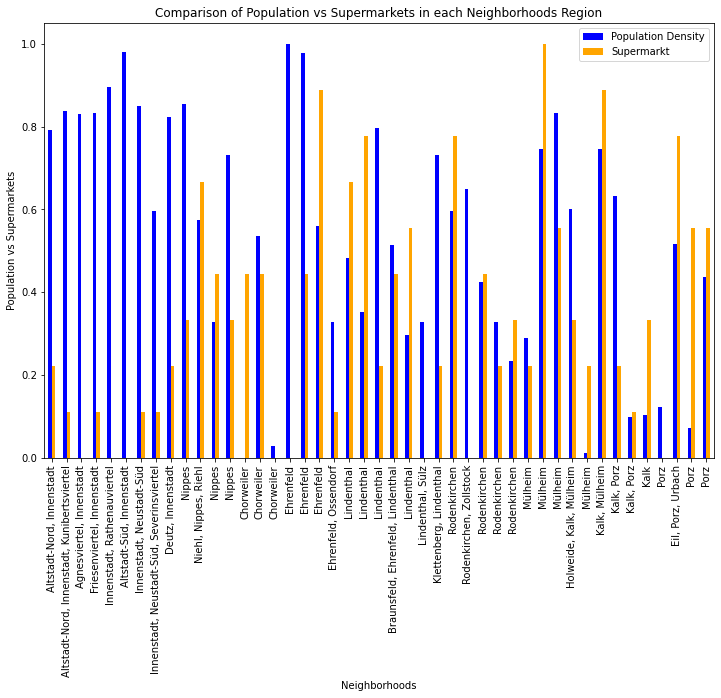

In [78]:
cologne_grouped_analysis.plot(kind='bar',x='Neighborhoods',y=['Population Density','Supermarkt'],
                              figsize=(12,8),color=['Blue','Orange'])
plt.title('Comparison of Population vs Supermarkets in each Neighborhoods Region')
plt.xlabel('Neighborhoods')
plt.ylabel('Population vs Supermarkets')
plt.show()

#### Above figure shows comparison of Normalized Population Density with Normalized Supermarkets value. Gives a rough estimate of scenario in the City

In [102]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [83]:
# DataFrame for clustering neighbourhoods based on Supermarkets
clusters=pd.DataFrame()
clusters['Supermarkt']=cologne_grouped_analysis['Supermarkt']

#### Find the best k value to cluster different regions

In [86]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    KM.fit(clusters)
    inertia.append(KM.inertia_/100)


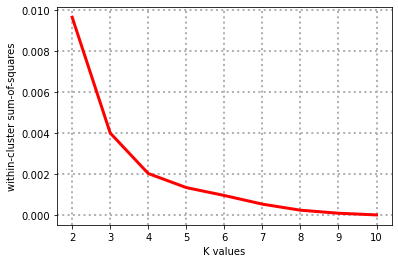

In [87]:
#plot the K values aganist the squared error cost
plt.plot(range(2,11), inertia, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('within-cluster sum-of-squares')
plt.grid(linestyle=':', linewidth=2)
plt.show()

#### k = 8 seems to be the best fit from above chart, so we can make 8 different clusters of cologne city to analyse the population density to Supermarket comparison

In [88]:
kclusters = 8

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clusters)

kmeans.labels_

array([3, 5, 1, 5, 1, 1, 5, 5, 3, 7, 4, 0, 7, 0, 0, 1, 1, 0, 2, 5, 4, 4,
       3, 0, 6, 1, 3, 4, 1, 0, 3, 7, 3, 2, 6, 7, 3, 2, 3, 5, 7, 1, 4, 6,
       6], dtype=int32)

In [109]:
#cologne_grouped_analysis.insert(10,'Cluster Label',kmeans.labels_)
cologne_grouped_analysis['Label'] = cologne_grouped_analysis['Postal Code']+' '+cologne_grouped_analysis['Neighborhoods']
cologne_grouped_analysis.head()

Postal Code                                Neighborhoods  Supermarkt  \
0       50667                    Altstadt-Nord, Innenstadt    0.222222   
1       50668  Altstadt-Nord, Innenstadt, Kunibertsviertel    0.111111   
2       50670                     Agnesviertel, Innenstadt    0.000000   
3       50672                   Friesenviertel, Innenstadt    0.111111   
4       50674                  Innenstadt, Rathenauviertel    0.000000   

   Population  Population Density   Latitude  Longitude  Male Population  \
0    0.000000            0.791061  50.940089   6.957685             2187   
1    0.051142            0.838764  50.950695   6.965450             3740   
2    0.065423            0.831463  50.951172   6.950957             4174   
3    0.002314            0.831963  50.943441   6.938476             2257   
4    0.034004            0.896072  50.933584   6.937041             3219   

   Female Population  Median Age  Cluster Label  \
0               2325  41.3 years              3   
1               3977  41.3 years              5   
2               4438  41.3 years              1   
3               2400  41.3 years              5   
4               3424  41.3 years              1   

                                               Label  
0                    50667 Altstadt-Nord, Innenstadt  
1  50668 Altstadt-Nord, Innenstadt, Kunibertsviertel  
2                     50670 Agnesviertel, Innenstadt  
3                   50672 Friesenviertel, Innenstadt  
4                  50674 Innenstadt, Rathenauviertel

In [110]:
Cluster1 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==0]
Cluster2 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==1]
Cluster3 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==2]
Cluster4 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==3]
Cluster5 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==4]
Cluster6 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==5]
Cluster7 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==6]
Cluster8 = cologne_grouped_analysis[cologne_grouped_analysis['Cluster Label']==7]

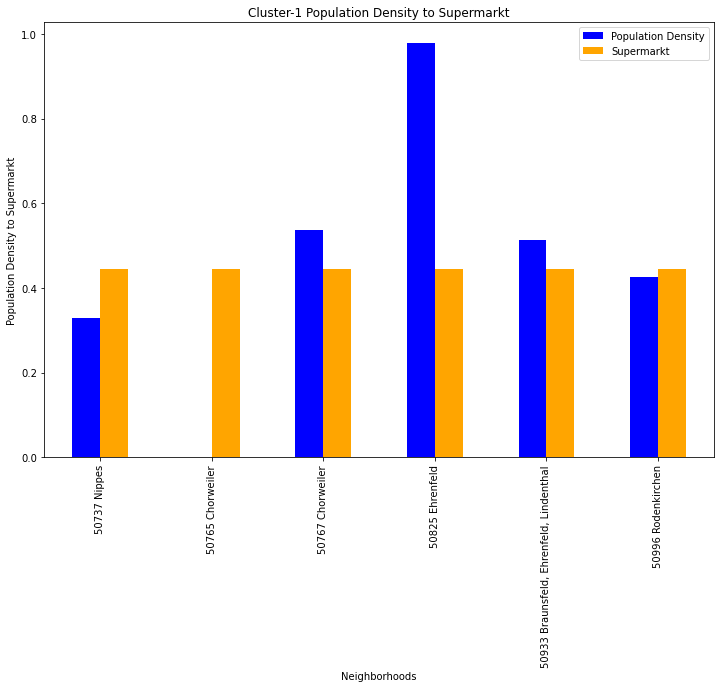

In [111]:
Cluster1.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-1 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

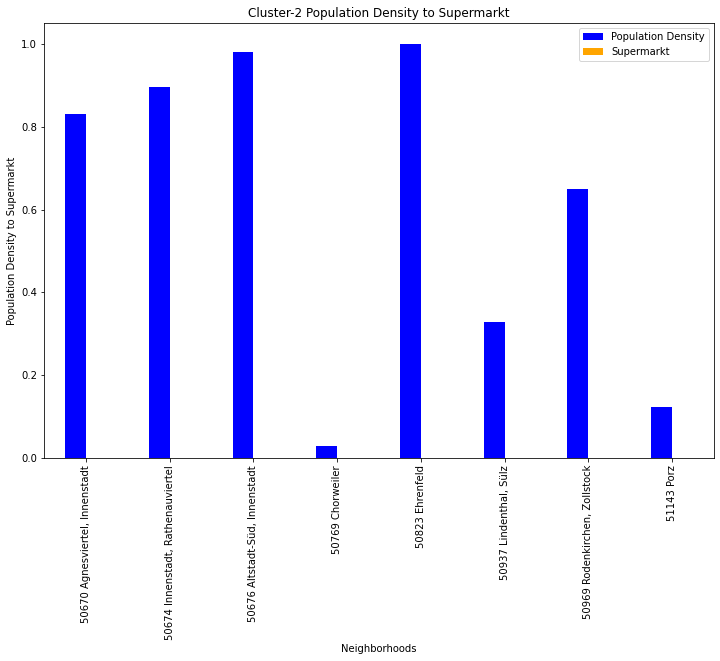

In [112]:
Cluster2.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-2 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

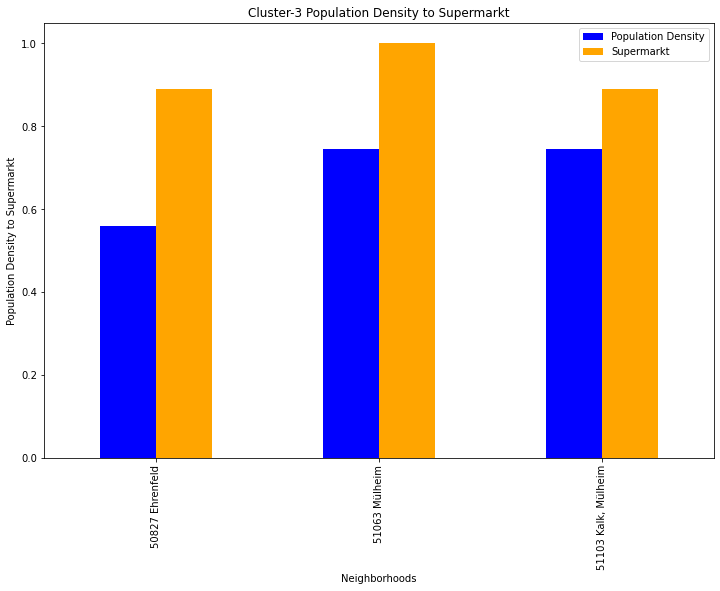

In [113]:
Cluster3.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-3 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

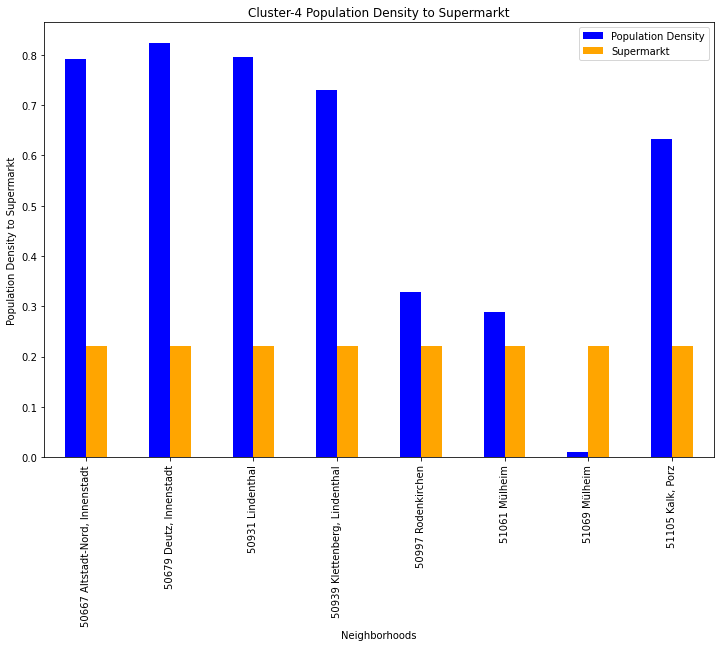

In [114]:
Cluster4.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-4 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

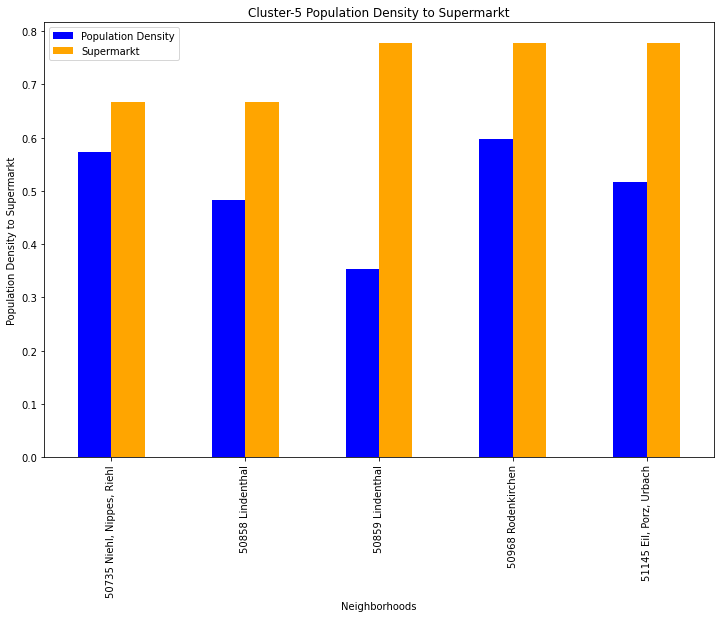

In [115]:
Cluster5.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-5 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

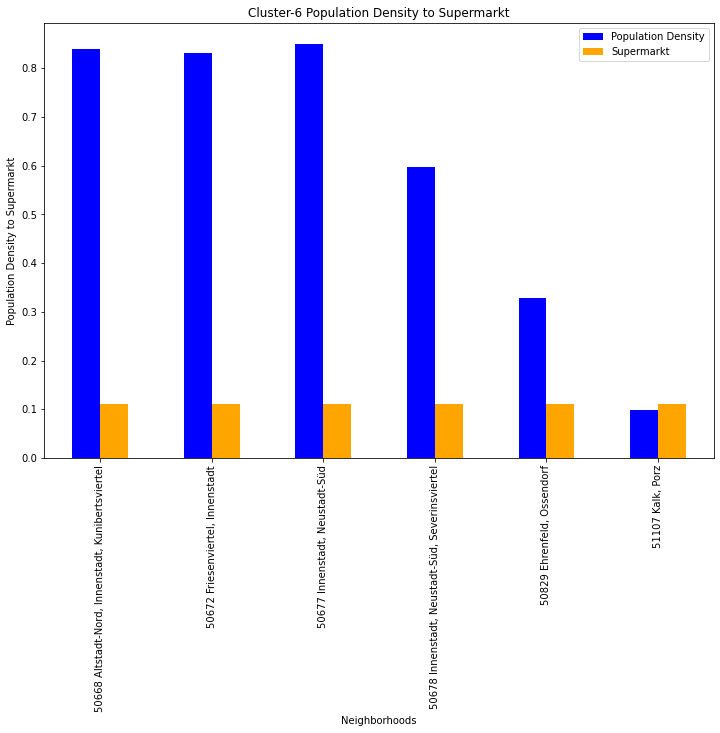

In [116]:
Cluster6.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-6 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

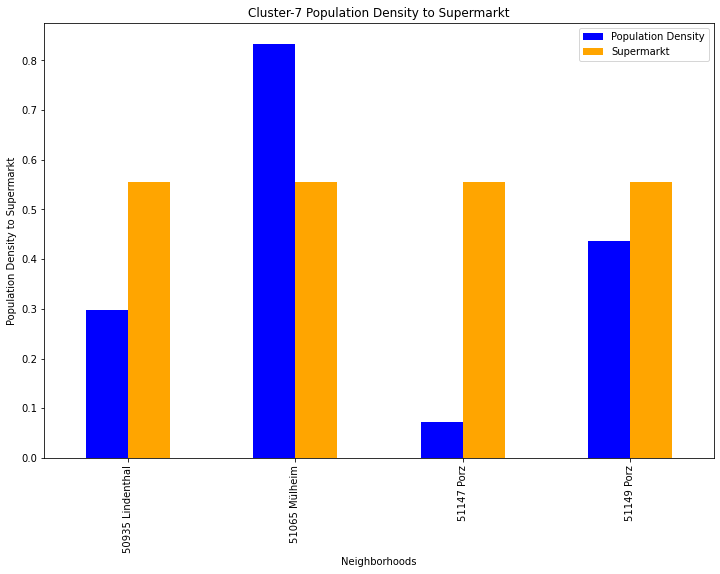

In [117]:
Cluster7.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-7 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

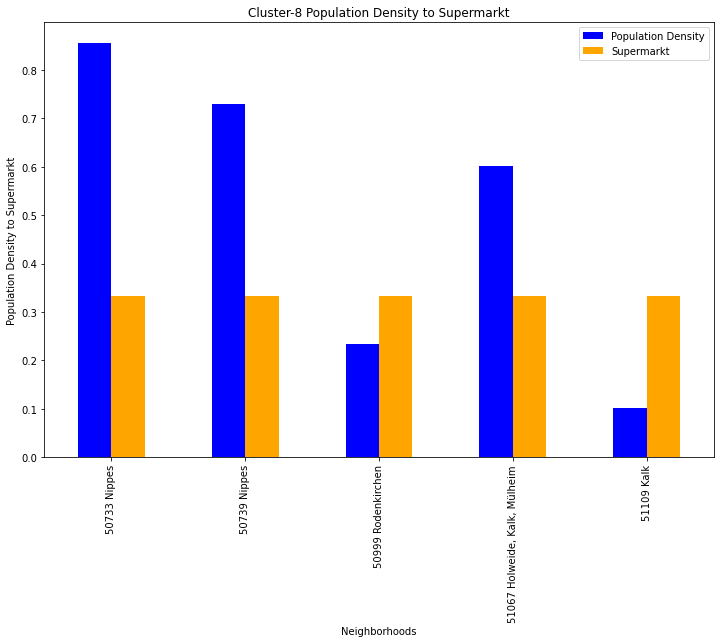

In [118]:
Cluster8.plot(kind='bar',x='Label',y=['Population Density','Supermarkt'],
              figsize=(12,8),color=['Blue','Orange'])
plt.title("Cluster-8 Population Density to Supermarkt")
plt.xlabel("Neighborhoods")
plt.ylabel("Population Density to Supermarkt")
plt.show()

In [121]:
mchoropleth1 = folium.Map(location = [50.935173,6.953101],tiles='openstreetmap',zoom_start = 11)
mchoropleth1.choropleth(
    geo_data = cologne_json,
    data = df_colognedata,
    columns = ['Postal Code','Population Density'],
    key_on = "feature.properties.NUMMER",
    fill_color="YlGn",
    name = "Population Density in Cologne, Germany",
    )
folium.LayerControl().add_to(mchoropleth1)
k=kclusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lng, label,clust in zip(cologne_grouped_analysis['Latitude'], cologne_grouped_analysis['Longitude'], 
                                  cologne_grouped_analysis['Neighborhoods'],cologne_grouped_analysis['Cluster Label']):
    label = folium.Popup(label+'\n'+str(clust), parse_html=True)
    #rad = binned
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7,
        parse_html=False).add_to(mchoropleth1)
mchoropleth1

## End of Analysis. Thanks